# Modelo para predicción de valor de mercado para autos

El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

## Instalación de librerías

In [87]:
pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [88]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Librerías

In [89]:
import pandas as pd
import numpy as np
import scipy.stats as st
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor

In [90]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preparación de datos

Primeramente se procede a leer el Data Frame

In [91]:
df = pd.read_csv('/content/drive/MyDrive/practicum/Sprint12/car_data.csv')

In [92]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


A simple vista se evidencia la presencia de valores nulos, tomando esto en cuenta se procede a realizar el conteo de la cfilas y determinacón de tipo de datos

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [94]:
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Se observa una muestra de valores extraños al emplear la descripción de lso datos, en la columna de `'RegistrationYear'` Se evidencia que existen años muy superiores al año cursante luego del tercer cuartil, y antes dle primer cuartil, también se evidencian valores muy por debajo incluso de la epoca en la que los autos existían, para observar esto de mejor manera se realiza un gráfico de caja y bigotes. 

<Axes: >

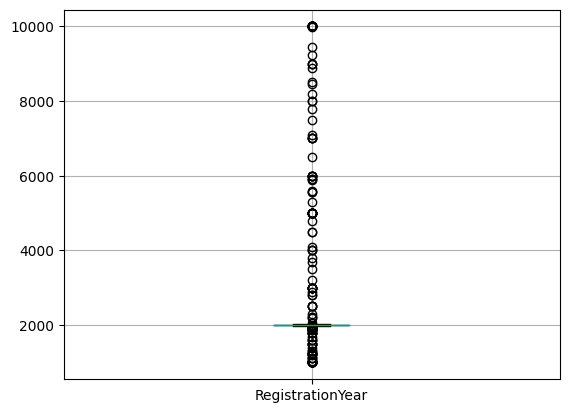

In [95]:
df.boxplot('RegistrationYear')

Para solucionar este problema, se ópta por truncar los valores desde 1985, hasta el 2023, ya que así eliminamos los atípicos.

In [96]:
original_length = len(df)    #Almacenamos el valor del tamaño original del DataFrame para poder derminar posteriomente la cantidad de valores eliminados

In [97]:
df = df[(df['RegistrationYear'] < 2023 )& (df['RegistrationYear'] > 1985)]

<Axes: >

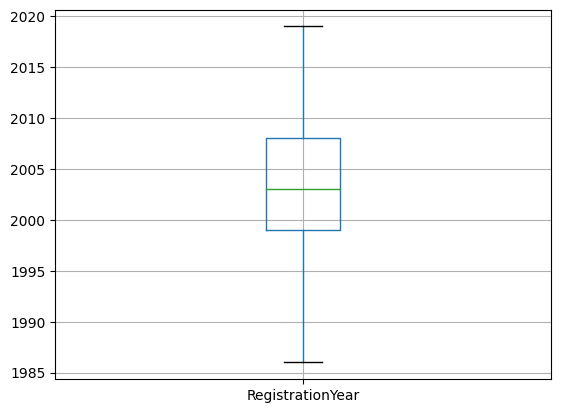

In [98]:
df.boxplot('RegistrationYear')

Como se observa, ya los valores tiene más sentido, realizando el cálculo de los datos perdidos en este caso, tenemos que:

In [99]:
(original_length  - len(df))*100 /354369 

1.7803476037689527

Solamente se perdió el 1.78% de los datos una cifra bastante insignificante que no afectará el resultado final

Se observa que la cantidad de nulos es considerble y al tratarse de observaciones categóricas, en este caso, no sería correcto que sean sutituidas por los valores más communes como la moda, o por alguna distribución aleatoria, ya que entrenaríamos al modelo con modelos de autos innexistentes, lo cual puede que a futuro ocacione algun error que conlleve a una mala predicción. Es por ello que se opta por borrarlos. Sin embargo antes, se evidenciará cual será el porcentaje de perdida

In [100]:
(len(df) -283215)*100 / len(df)

18.630408550249957

Como se evidencia es bastante alto, estamo en torno al 20% de datos borrados, sin embargo, por lo antes descritos, se puede considerar un mal necesario.

In [101]:
df = df.drop(df[df['VehicleType'].isna()].index, axis = 0)

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311730 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        311730 non-null  object
 1   Price              311730 non-null  int64 
 2   VehicleType        311730 non-null  object
 3   RegistrationYear   311730 non-null  int64 
 4   Gearbox            302430 non-null  object
 5   Power              311730 non-null  int64 
 6   Model              299794 non-null  object
 7   Mileage            311730 non-null  int64 
 8   RegistrationMonth  311730 non-null  int64 
 9   FuelType           296714 non-null  object
 10  Brand              311730 non-null  object
 11  NotRepaired        262428 non-null  object
 12  DateCreated        311730 non-null  object
 13  NumberOfPictures   311730 non-null  int64 
 14  PostalCode         311730 non-null  int64 
 15  LastSeen           311730 non-null  object
dtypes: int64(7), object(

In [103]:
df = df.drop(df[df['Gearbox'].isna()].index, axis = 0)

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302430 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        302430 non-null  object
 1   Price              302430 non-null  int64 
 2   VehicleType        302430 non-null  object
 3   RegistrationYear   302430 non-null  int64 
 4   Gearbox            302430 non-null  object
 5   Power              302430 non-null  int64 
 6   Model              291454 non-null  object
 7   Mileage            302430 non-null  int64 
 8   RegistrationMonth  302430 non-null  int64 
 9   FuelType           289234 non-null  object
 10  Brand              302430 non-null  object
 11  NotRepaired        257248 non-null  object
 12  DateCreated        302430 non-null  object
 13  NumberOfPictures   302430 non-null  int64 
 14  PostalCode         302430 non-null  int64 
 15  LastSeen           302430 non-null  object
dtypes: int64(7), object(

In [105]:
df = df.drop(df[df['Model'].isna()].index, axis = 0)

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291454 entries, 2 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        291454 non-null  object
 1   Price              291454 non-null  int64 
 2   VehicleType        291454 non-null  object
 3   RegistrationYear   291454 non-null  int64 
 4   Gearbox            291454 non-null  object
 5   Power              291454 non-null  int64 
 6   Model              291454 non-null  object
 7   Mileage            291454 non-null  int64 
 8   RegistrationMonth  291454 non-null  int64 
 9   FuelType           280497 non-null  object
 10  Brand              291454 non-null  object
 11  NotRepaired        249910 non-null  object
 12  DateCreated        291454 non-null  object
 13  NumberOfPictures   291454 non-null  int64 
 14  PostalCode         291454 non-null  int64 
 15  LastSeen           291454 non-null  object
dtypes: int64(7), object(

In [107]:
df = df.drop(df[df['FuelType'].isna()].index, axis = 0)

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280497 entries, 2 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        280497 non-null  object
 1   Price              280497 non-null  int64 
 2   VehicleType        280497 non-null  object
 3   RegistrationYear   280497 non-null  int64 
 4   Gearbox            280497 non-null  object
 5   Power              280497 non-null  int64 
 6   Model              280497 non-null  object
 7   Mileage            280497 non-null  int64 
 8   RegistrationMonth  280497 non-null  int64 
 9   FuelType           280497 non-null  object
 10  Brand              280497 non-null  object
 11  NotRepaired        242910 non-null  object
 12  DateCreated        280497 non-null  object
 13  NumberOfPictures   280497 non-null  int64 
 14  PostalCode         280497 non-null  int64 
 15  LastSeen           280497 non-null  object
dtypes: int64(7), object(

Por último al tratarse de una condición de si el auto ha sido o no reparado, se opta por colocar que no a los valores nulos, ya que es lo más probale en la mayoriaía de los casos.

In [109]:
df['NotRepaired'].unique()

array([nan, 'no', 'yes'], dtype=object)

In [110]:
df['NotRepaired'] = df['NotRepaired'].fillna('no')

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280497 entries, 2 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        280497 non-null  object
 1   Price              280497 non-null  int64 
 2   VehicleType        280497 non-null  object
 3   RegistrationYear   280497 non-null  int64 
 4   Gearbox            280497 non-null  object
 5   Power              280497 non-null  int64 
 6   Model              280497 non-null  object
 7   Mileage            280497 non-null  int64 
 8   RegistrationMonth  280497 non-null  int64 
 9   FuelType           280497 non-null  object
 10  Brand              280497 non-null  object
 11  NotRepaired        280497 non-null  object
 12  DateCreated        280497 non-null  object
 13  NumberOfPictures   280497 non-null  int64 
 14  PostalCode         280497 non-null  int64 
 15  LastSeen           280497 non-null  object
dtypes: int64(7), object(

En total se eliminó el:

In [112]:
(original_length-len(df))*100 / original_length

20.846067235000802

Como se predijo se eliminó 1/5 de los datos, sin embargo, es un mal necesario para velar por el buen funcionamiento del modelo a futuro, y que de esta manera cosas como un Toyota Aveo a disel no existan

## Entrenamiento del modelo 

Previamente antes de  entrenar el modelo que nos permita determinar cual es el precio de un auto. se deben eliminar las características que no aportan nada a la predicción ya que no es una carcaterística del auto persé y por tanto no influye en su precio. Estas serían la fecha en la que la persona se inscribión en la página, el mes de matriculación del vehículo, el código postal, la ultimas vez quelio vieron, y el número de fotos en la publicación.

In [113]:
df_clean = df.drop(['DateCrawled','DateCreated',	'PostalCode',	'LastSeen','RegistrationMonth','NumberOfPictures'], axis = 1)

In [137]:
df_clean = df_clean.reset_index(drop = True)

In [138]:
df_clean.head(10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired
0,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
1,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
2,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
3,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
4,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
5,14500,bus,2014,manual,125,c_max,30000,petrol,ford,no
6,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no
7,2799,wagon,2005,manual,140,passat,150000,gasoline,volkswagen,yes
8,999,wagon,1995,manual,115,passat,150000,petrol,volkswagen,no
9,17999,suv,2011,manual,190,navara,70000,gasoline,nissan,no


Para poder realizar un algoritmo de machine learning que nos permita encontar el precio del vehículo, se deben pasar las variables categótricas a númericas, y luego estandaraixzar todo, para no dar más relecvancia a ciertos algotirmos más qeu a otros. 

In [139]:
encoder = OrdinalEncoder()

In [140]:
categ = ['VehicleType',	'Gearbox', 'Model',	'FuelType',	'Brand',	'NotRepaired']
numeric = ['Price', 'RegistrationYear',	'Power',	'Mileage']

Se procede a la trnasformación de categóricas a numéricas

In [141]:
data_ordinal_categ = pd.DataFrame(encoder.fit_transform(df_clean[categ]),columns=categ)  

Se realiza el concatenado de las numéricas con las categóricas 

In [144]:
data_ordinal = pd.concat([data_ordinal_categ, df_clean[numeric]], axis = 1)

In [145]:
data_ordinal.head()

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,Price,RegistrationYear,Power,Mileage
0,6.0,0.0,117.0,2.0,14.0,0.0,9800,2004,163,125000
1,5.0,1.0,116.0,6.0,37.0,0.0,1500,2001,75,150000
2,5.0,1.0,101.0,2.0,31.0,0.0,3600,2008,69,90000
3,4.0,1.0,11.0,6.0,2.0,1.0,650,1995,102,150000
4,1.0,1.0,8.0,6.0,25.0,0.0,2200,2004,109,150000


In [146]:
scaler = StandardScaler()

In [152]:
var_to_scaler = ['Price', 'RegistrationYear',	'Power',	'Mileage', 	'NotRepaired']
var_not_scaler = ['VehicleType',	'Gearbox', 'Model',	'FuelType',	'Brand']

In [154]:
data_to_scaled = pd.DataFrame(scaler.fit_transform(data_ordinal[var_to_scaler ]), columns = var_to_scaler )

In [156]:
data_scaled = pd.concat([data_to_scaled , data_ordinal[var_not_scaler]], axis = 1)

In [173]:
data_scaled.head(10)

,Price,RegistrationYear,Power,Mileage,NotRepaired,VehicleType,Gearbox,Model,FuelType,Brand
0,1.074836,0.201303,0.264221,-0.098212,-0.329466,6.0,0.0,117.0,2.0,14.0
1,-0.718813,-0.350823,-0.253514,0.587761,-0.329466,5.0,1.0,116.0,6.0,37.0
2,-0.264998,0.937470,-0.288814,-1.058575,-0.329466,5.0,1.0,101.0,2.0,31.0
3,-0.902500,-1.455074,-0.094664,0.587761,3.035213,4.0,1.0,11.0,6.0,2.0
4,-0.567542,0.201303,-0.053480,0.587761,-0.329466,1.0,1.0,8.0,6.0,25.0
5,2.090517,2.041721,0.040653,-2.704912,-0.329466,0.0,1.0,60.0,6.0,10.0
6,-0.610762,0.201303,-0.077014,0.587761,-0.329466,4.0,1.0,10.0,6.0,19.0
7,-0.438096,0.385344,0.128904,0.587761,3.035213,7.0,1.0,170.0,2.0,37.0
8,-0.827080,-1.455074,-0.018180,0.587761,-0.329466,7.0,1.0,170.0,6.0,37.0
9,2.846659,1.489595,0.423071,-1.607354,-0.329466,6.0,1.0,159.0,2.0,23.0


In [158]:
data_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280497 entries, 0 to 280496
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             280497 non-null  float64
 1   RegistrationYear  280497 non-null  float64
 2   Power             280497 non-null  float64
 3   Mileage           280497 non-null  float64
 4   NotRepaired       280497 non-null  float64
 5   VehicleType       280497 non-null  float64
 6   Gearbox           280497 non-null  float64
 7   Model             280497 non-null  float64
 8   FuelType          280497 non-null  float64
 9   Brand             280497 non-null  float64
dtypes: float64(10)
memory usage: 21.4 MB


Una vez escaldos y demostrando que no hay valores nulos, se procede a dividir el conjunto de entreanmiento en features y targests y a su vez en entrenamiento y validación.

In [160]:
X = data_scaled.drop(['Price'], axis = 1)
y = data_scaled['Price']

In [161]:
X_train, X_valid, y_train, y_valid = train_test_split(X , y, test_size=0.40, random_state=12345)

In [162]:
X_valid, X_test, y_valid, y_test = train_test_split(X_valid , y_valid, test_size=0.50, random_state=12345)

In [165]:
X_train.shape

(168298, 9)

In [166]:
X_valid.shape

(56099, 9)

In [167]:
X_test.shape

(56100, 9)

Primeramente se realiza un algoritmo de regresión lineal, con la finalidad de que sirva como punto de comparación para el resto de modelos.

In [172]:
X.isna()

,RegistrationYear,Power,Mileage,NotRepaired,VehicleType,Gearbox,Model,FuelType,Brand
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
280492,False,False,False,False,False,False,False,False,False
280493,False,False,False,False,False,False,False,False,False
280494,False,False,False,False,False,False,False,False,False
280495,False,False,False,False,False,False,False,False,False


### Regresión lineal

In [218]:
%time
model_reg = LinearRegression()
model_reg.fit(X_train,y_train)
predict_reg = model_reg.predict(X_valid)
print(f'RMSE = {round(mean_squared_error(y_valid,predict_reg)**(1/2) * 100,2)} %')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs
RMSE = 67.32 %


Como se observa, aplicando la metrica de la raiz del error cuadrático medio podemos observar que está por eciam del 50% de error, por l que ese modelo es inviable para poder ser presentado a una empresa.

Se obtuvieron resultados muy similares al anterior

Se procede a emplear la librería LightGBM modificando los hiperparámetros para encontrar el modelo con el menor RMSE

### LightGBM

En este caso ópta por modificar los hiperparámetros:

`boosting_type`: que hace referencia al tipo de modelo que se utilizará para predecir la característica.

* `gbdt`, traditional Gradient Boosting Decision Tree, aliases: gbrt

* `dart`, Dropouts meet Multiple Additive Regression Trees

* `goss`, Gradient-based One-Side Sampling

`num_leaves`: cantidad de hojas que emplea el arbol de decisión.

`max_depth `: Profundidad del bosque.

`n_estimators `: cantidad de estimadores.

In [219]:
%time
best_LGBM_model = None
best_LGBM_rmse = 100
booster = None
num_l = 0
estimator = 0
depth = 0
for i in range(100,150,10):
  for j in ['gbdt', 'dart','goss']:
    for k in range(10,20,5):
      for l in range(130,150, 10):
        model_LGBM = LGBMRegressor(boosting_type= j,  num_leaves= l, max_depth =k,  learning_rate=0.1, n_estimators =i)
        model_LGBM.fit(X_train,y_train)
        predict_LGBM = model_LGBM.predict(X_valid)
        RMSE = mean_squared_error(y_valid,predict_LGBM )**(1/2) * 100
        if RMSE < best_LGBM_rmse:
          best_LGBM_model = model_LGBM
          best_LGBM_rmse = RMSE
          booster = j
          num_l = l
          estimator = i
          depth = k
          print(best_LGBM_rmse)

print(f'El modelo utilizado fue un: "{booster}", con {num_l} hojas, {estimator} estimadores y una profundidad de: {depth}')       
print(f'The best RMSE = {round(best_LGBM_rmse,2)} %')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs
35.30647801960531
35.223912884613526
35.12198514422477
35.10741173600943
35.01941721349558
34.99804524777584
34.9270492898592
34.88891104914602
34.86080941598524
34.81741869735373
34.78182546312504
34.735145685981266
34.72086079462585
El modelo utilizado fue un: "goss", con 140 hojas, 140 estimadores y una profundidad de: 15
The best RMSE = 34.72 %


Como se puede observar, el mejor modelo obtenido, RMSE de 34,72% lo cual es bastante bajo, arrojando una muy buena predicción en este sentido.

Así mismo se observa que modelo que mejor se ajusta es el goss, que no es más que otro tipo de descenso de gradiente.

### Decision_Tree_Regressor

In [220]:
%time
kf = KFold(n_splits=5)
RMSE = 100
best_model_RT = None
scores = []
for d in [15,16,17,18,19,20]:
  for splitter in [2,4,6,8,10]:
    model = DecisionTreeRegressor(max_depth = d, min_samples_split = splitter, random_state=42)
    score = []
    for fold,(train_idx, val_idx) in enumerate(kf.split(X), start = 1):
      X_train = X.loc[train_idx].reset_index(drop = True)
      y_train = y.loc[train_idx].reset_index(drop = True) 
      X_val = X.loc[val_idx].reset_index(drop = True)
      y_val = y.loc[val_idx].reset_index(drop = True)  

      model.fit(X_train,y_train)  
      y_pred = pd.DataFrame(model.predict(X_val))
      score.append(mean_squared_error(y_val, y_pred)**(1/2))
      
      print(f"Score for fold {fold}: {mean_squared_error(y_val, y_pred)**(1/2)}")
    if np.mean(score) < RMSE:
      RMSE = np.mean(score)
      best_model_RT = model                    
    
    print(f'La media de los valores es: {np.mean(score)}\n')
    score = []
  scores.append(score)
print(f'El mejor RMSE es: {round(RMSE*100,2)} %')


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs
Score for fold 1: 0.3937472969913987
Score for fold 2: 0.4001386587794706
Score for fold 3: 0.3988142380357951
Score for fold 4: 0.3902618445424788
Score for fold 5: 0.39150589437044925
La media de los valores es: 0.3948935865439185

Score for fold 1: 0.3924004794645632
Score for fold 2: 0.39699695973265936
Score for fold 3: 0.3973012901002097
Score for fold 4: 0.38633225958921846
Score for fold 5: 0.38931774656608814
La media de los valores es: 0.39246974709054777

Score for fold 1: 0.3906634238824108
Score for fold 2: 0.3955619538168692
Score for fold 3: 0.39625307710408103
Score for fold 4: 0.3840109147421899
Score for fold 5: 0.38628381179415217
La media de los valores es: 0.3905546362679407

Score for fold 1: 0.3886014923628911
Score for fold 2: 0.3940804957924605
Score for fold 3: 0.39368411228245154
Score for fold 4: 0.3842289137572944
Score for fold 5: 0.38553487974426015
La media de los valores es: 0.3892259787878

Este modelo el cual utiliza un arbol de desición por medio de un metodo de validación cruzada empleando varios fold y obteniendo un RMSE del 38.47 % más elevado que en el caso anterior

### CatBoost

In [221]:
%time
model_CAT = CatBoostRegressor(iterations = 150 ,  loss_function='RMSE')
model_CAT.fit(X_train,y_train, verbose=10 )
predict_CAT = model_CAT.predict(X_valid)
RMSE = mean_squared_error(y_valid,predict_CAT )**(1/2) * 100

        
print(f'The best RMSE = {round(RMSE,2)} %')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs
Learning rate set to 0.450276
0:	learn: 0.7160489	total: 87.4ms	remaining: 13s
10:	learn: 0.4152673	total: 401ms	remaining: 5.07s
20:	learn: 0.3936107	total: 689ms	remaining: 4.24s
30:	learn: 0.3828796	total: 1.02s	remaining: 3.91s
40:	learn: 0.3761675	total: 1.31s	remaining: 3.48s
50:	learn: 0.3703201	total: 1.6s	remaining: 3.1s
60:	learn: 0.3652368	total: 1.92s	remaining: 2.81s
70:	learn: 0.3616933	total: 2.23s	remaining: 2.49s
80:	learn: 0.3585128	total: 2.56s	remaining: 2.19s
90:	learn: 0.3554049	total: 2.87s	remaining: 1.86s
100:	learn: 0.3526720	total: 3.15s	remaining: 1.53s
110:	learn: 0.3505557	total: 3.45s	remaining: 1.21s
120:	learn: 0.3486757	total: 3.74s	remaining: 897ms
130:	learn: 0.3471730	total: 4.05s	remaining: 588ms
140:	learn: 0.3455212	total: 4.35s	remaining: 278ms
149:	learn: 0.3440723	total: 4.61s	remaining: 0us
The best RMSE = 35.2 %


Aplicando un modelo por medio de la librería CatBoost, podemos observar que el erro cuadrático medio obtenido es de 36.7%, un excelente valor, aunque menor que el obtenido en el LGBM 

## Análisis del modelo

Si realizamos el análisis de la velocidad de predicción de cada uno de los mejores modelos tenemos que:

Predicción del modelo de regresión lineal

In [222]:
%time
predict_reg = model_reg.predict(X_valid)
print(f'RMSE = {round(mean_squared_error(y_valid,predict_reg)**(1/2) * 100,2)} %')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs
RMSE = 67.32 %


Tarda 4us segundos es casi instantaneo, sin embargo su RMSE es de 67.32% lo cual habla de una calidad de modelo bastante baja

Se prosige nalizando la velocidad del algoritmo de LGBMRegressor

In [223]:
%time
predict_LGBM= model_LGBM.predict(X_valid)
RMSE = mean_squared_error(y_valid,predict_LGBM )**(1/2) * 100
print(f'RMSE = {round(RMSE ,2)} %')

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 7.39 µs
RMSE = 34.72 %


Este código tiene una RMSE de 34.72% casi la mitad del anterior, siendo bastante eficiente, y al mismo tiempo solo tarda 8 us en ejecutarse, un poco superior sin embargo bastante rápido

In [224]:
%time
predict_CAT = model_CAT.predict(X_valid)
RMSE = mean_squared_error(y_valid,predict_CAT )**(1/2) * 100

        
print(f'RMSE = {round(RMSE,2)} %')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs
RMSE = 35.2 %


Así mismo,revisando el algoritmo de CatBoost, podemos observar que en 200 iteraciones logró un RMSE de 35.2 % en tan solo 4 us, siendo bastante rapido, y con una diferencia de solo 1.18% entre el modelo de LGBM y el de CatBoost

Por último se realiza la prueba con el modelo de arbol de decisión. 

In [225]:
%time
predict_RT = best_model_RT.predict(X_valid)
RMSE = mean_squared_error(y_valid,predict_RT )**(1/2) * 100

        
print(f'RMSE = {round(RMSE,2)} %')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs
RMSE = 30.94 %


Se obtuvo un RMSE del 30.94% el más bajo hasta ahora, obteniendo incluso un timepo de ejecución de 4 us. Siendo el que mejor calidad aporta hasta ahora, y el más rápido.

## Conclusión General

Primeramente, al realizar el análisis de los datos, se observa que la cantidad de nulos es considerble y al tratarse de observaciones categóricas, en este caso, no sería correcto que sean sutituidas por los valores más communes como la moda, o por alguna distribución aleatoria, ya que entrenaríamos al modelo con modelos de autos innexistentes, lo cual puede que a futuro ocacione algun error que conlleve a una mala predicción. Es por ello que se opta por borrarlos, ya que el porcentaje de perdedia oscila en el 20% de los datos, y aunque esto representa un 1/5 de los mismos, es un mal necesario para garantizar que el modelo funciona adecuadamente.

### **Resultado de los modelos**

#### **Regresión lineal**

Tarda 4us segundos es casi instantaneo, sin embargo su RMSE es de 67.32% lo cual habla de una calidad de modelo bastante baja

#### LGBMRegressor

Este código tiene una RMSE de 34.72% casi la mitad del anterior, siendo bastante eficiente, y al mismo tiempo solo tarda 8 us en ejecutarse, un poco superior sin embargo bastante rápido.

#### CatBoost

Así mismo,revisando el algoritmo de CatBoost, podemos observar que en 200 iteraciones logró un RMSE de 35.2 % en tan solo 4 us, siendo bastante rapido, y con una diferencia de solo 1.18% entre el modelo de LGBM y el de CatBoost

#### Arbol de decisión aleatorio

Se obtuvo un RMSE del 30.94% el más bajo hasta ahora, obteniendo incluso un timepo de ejecución de 4 us. Siendo el que mejor calidad aporta hasta ahora, y el más rápido.

Se puede concluir que luego de realizar un análisis de los datos, eliminar aquellos que no servian para el análisis y porbar 6 modelos diferentes, se llega a la conclusión general que el modelo que aporta un menor RMSE es el arbol de desición el cual empleó un método de validación cruzada, y con ello se llegó al mejor resultado posible. 